## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from normalizer import normalizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   prev_sold_date  7617 non-null   object 
 6   price           7617 non-null   float64
dtypes: float64(6), object(1)
memory usage: 416.7+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7617 entries, 0 to 7616
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7617 non-null   float64
 1   bath            7617 non-null   float64
 2   acre_lot        7617 non-null   float64
 3   zip_code        7617 non-null   float64
 4   house_size      7617 non-null   float64
 5   price           7617 non-null   float64
 6   prev_sold_year  7617 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 416.7 KB


In [5]:
params = {
    "data":outliers_df,
    "features_a":["zip_code","price","prev_sold_year"],
    "features_n":["bed","bath","acre_lot","house_size"]
    
}
normalize_df = normalizer(params)
normalize_df.head()

,bed,bath,acre_lot,house_size,zip_code,price,prev_sold_year
0,0.001946,0.001297,0.000091,0.999997,7001.0,305100.0,2022
1,0.002000,0.001333,0.000073,0.999997,7001.0,479000.0,2016
2,0.000400,0.000267,0.000023,1.000000,7001.0,340000.0,2021
3,0.003605,0.001442,0.000130,0.999992,7001.0,484000.0,2020
4,0.002000,0.001333,0.000113,0.999997,7001.0,425000.0,2019


#### Create a new feature in the housing data for Zip Code with a leading zero

In [6]:
normalize_df["zip_code_str"] = np.where(normalize_df.zip_code.apply(int) < 10000,'0'+ normalize_df.zip_code.apply(int).apply(str),normalize_df.zip_code.apply(int).apply(str))
normalize_df.head()

,bed,bath,acre_lot,house_size,zip_code,price,prev_sold_year,zip_code_str
0,0.001946,0.001297,0.000091,0.999997,7001.0,305100.0,2022,07001
1,0.002000,0.001333,0.000073,0.999997,7001.0,479000.0,2016,07001
2,0.000400,0.000267,0.000023,1.000000,7001.0,340000.0,2021,07001
3,0.003605,0.001442,0.000130,0.999992,7001.0,484000.0,2020,07001
4,0.002000,0.001333,0.000113,0.999997,7001.0,425000.0,2019,07001


#### Create a new feature in the Lat/Long data for Zip Code with a leading zero

In [7]:
zip_lon_lat = pd.read_csv('nj_zip-lon-lat.csv')
zip_lon_lat["zip_code_str"] = np.where(zip_lon_lat.zip_code.apply(int) < 10000,'0'+ zip_lon_lat.zip_code.apply(int).apply(str),zip_lon_lat.zip_code.apply(int).apply(str))
zip_lon_lat.head()

,zip_code,latitude,longitude,zip_code_str
0,7001,40.582316,-74.271506,07001
1,7002,40.662338,-74.110275,07002
2,7003,40.809128,-74.187155,07003
3,7004,40.882508,-74.304593,07004
4,7005,40.932771,-74.417304,07005


#### Merge the Lat/Long data with the housing data using Zip Code with a leading zero

In [8]:
merged_df = pd.merge(normalize_df, zip_lon_lat, how='inner', on="zip_code_str")
merged_df.tail()

,bed,bath,acre_lot,house_size,zip_code_x,price,prev_sold_year,zip_code_str,zip_code_y,latitude,longitude
7609,0.003333,0.002667,0.000607,0.999991,8848.0,485000.0,2017,08848,8848,40.594266,-75.096659
7610,0.002667,0.002000,0.001447,0.999993,8825.0,510000.0,2016,08825,8825,40.514169,-75.027112
7611,0.002000,0.001333,0.000080,0.999997,7012.0,499000.0,2021,07012,7012,40.848398,-74.160266
7612,0.002000,0.002000,0.000087,0.999996,7012.0,530000.0,2022,07012,7012,40.848398,-74.160266
7613,0.002667,0.002000,0.000073,0.999994,7640.0,720000.0,2016,07640,7640,40.991681,-73.980202


#### Create common variables to store frequently used values.

In [9]:
features = ["latitude","longitude","bed","bath","house_size"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [10]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [11]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [12]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [13]:
params = {'max_depth': range(5,15,1),
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 7, 'random_state': 42}

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [14]:
dtree = dosomething("Decision Tree","Decision Tree Best Params", merged_df, features, "price", best_params)
results_dict_append(dtree["results"])
dtree_bp_predict = dtree["predictions"]

Decision Tree Best Params EVS = 0.373649921
Decision Tree Best Params MSE = 100,846,173,380.094635
Decision Tree Best Params MAE = 205,324.060664
Decision Tree Best Params R2 = 0.373365
Decision Tree Best Params Fit Time = 0.012043237686157227


#### cost_complexity_pruning_path

path = dtree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [15]:
dtree_rfe = dosomething("Decision Tree","Recursive Feature Elimination", merged_df, features, "price")
results_dict_append(dtree_rfe["results"])
dtree_rfe_predict = dtree_rfe["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath']
Recursive Feature Elimination EVS = 0.267510036
Recursive Feature Elimination MSE = 117,942,750,509.330643
Recursive Feature Elimination MAE = 200,468.576924
Recursive Feature Elimination R2 = 0.267131
Recursive Feature Elimination Fit Time = 0.025658893585205077


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. 

In [16]:
dtree_sfs = dosomething("Decision Tree","Sequential Feature Selector", merged_df, features, "price")
results_dict_append(dtree_sfs["results"])
dtree_sfs_predict = dtree_sfs["predictions"]

The selected features are: ['longitude', 'bed', 'bath', 'house_size']
Sequential Feature Selector EVS = 0.265619739
Sequential Feature Selector MSE = 118,381,120,804.417694
Sequential Feature Selector MAE = 207,739.180416
Sequential Feature Selector R2 = 0.264407
Sequential Feature Selector Fit Time = 0.028362464904785157


#### Graphing the results works best when the data is provided in a DataFrame.

In [17]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### The predictions provided by the best parameters have the appearance of banding.  I will conduct more testing to determine if this is acceptable or if this is a case of underfitting or overfitting.

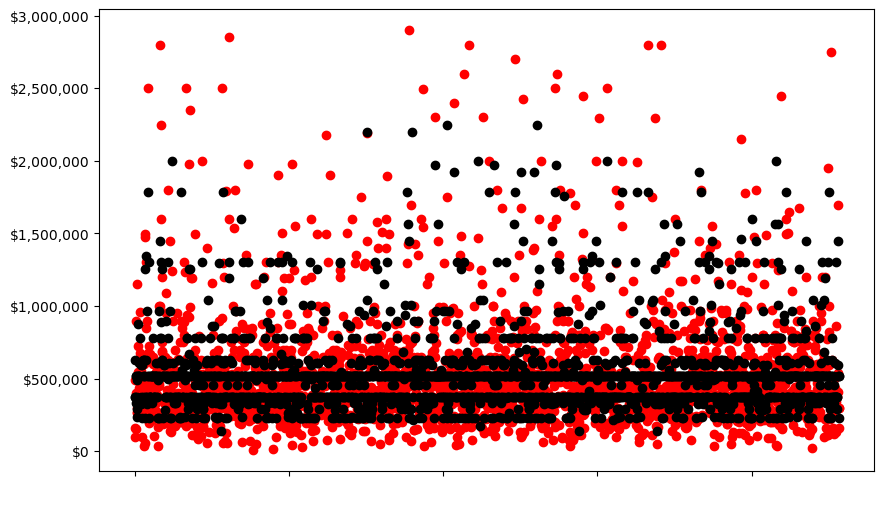

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

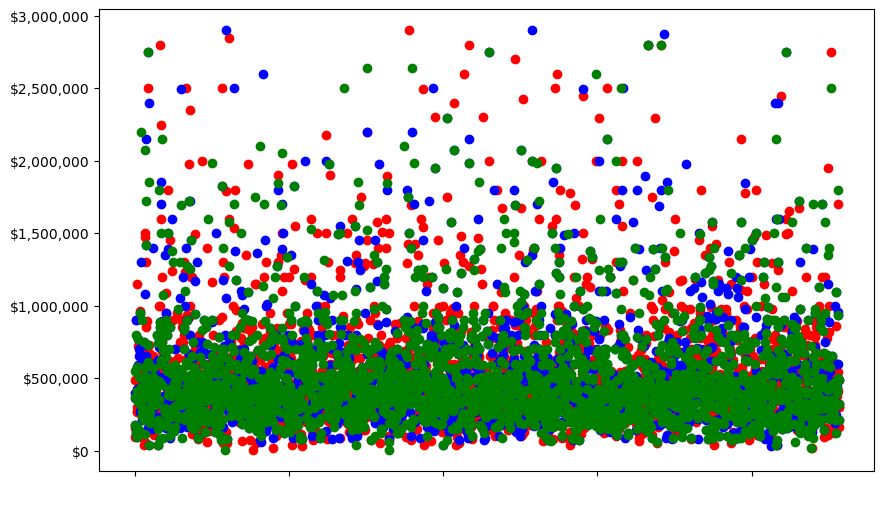

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [20]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.373649921', '0.267510036', '0.265619739'],
 'mae score': ['205,324.060664', '200,468.576924', '207,739.180416'],
 'mse score': ['100,846,173,380.094635',
  '117,942,750,509.330643',
  '118,381,120,804.417694'],
 'r2 score': ['0.373365', '0.267131', '0.264407'],
 'mean fit time': [0.012043237686157227,
  0.025658893585205077,
  0.028362464904785157]}

In [21]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.373649921,"205,324.060664","100,846,173,380.094635",0.373365,0.012043
Recursive Feature Elimination,0.267510036,"200,468.576924","117,942,750,509.330643",0.267131,0.025659
Sequential Feature Selector,0.265619739,"207,739.180416","118,381,120,804.417694",0.264407,0.028362
